In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
len(os.listdir('/content/drive/MyDrive/PRML Project/covid 19/inverse_masks/Non-Covid/'))

5428

In [5]:
len(os.listdir('/content/drive/MyDrive/PRML Project/covid 19/inverse_masks/Covid/'))

4044

In [6]:
dataset_path = '/content/drive/MyDrive/PRML Project/covid 19/inverse_masks'

In [7]:
dataset_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [8]:
def get_mean_and_std(loader):
  mean = 0.
  std = 0.
  total_images_count = 0
  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch
  mean /= total_images_count
  std /= total_images_count

  return mean, std 

In [9]:
from torchvision.transforms.transforms import RandomHorizontalFlip
dataset_transforms2 = transforms.Compose([
                                          transforms.Resize((224,224)), 
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation(10),
                                          transforms.ToTensor(),
                                        ])

In [10]:
dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = dataset_transforms2)

In [11]:
len(dataset)

9472

In [12]:
train_size = int(0.7 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,validation_size,test_size])

In [13]:
dataset_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 8, shuffle = True)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 8)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 8)

In [15]:
# get_mean_and_std(dataset_loader)

In [16]:
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("labels: ", labels)

labels:  tensor([1, 0, 0, 1, 0, 0])


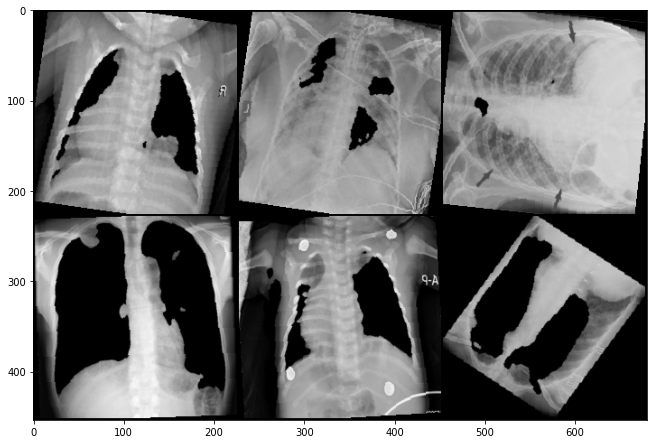

In [17]:
show_transformed_images(dataset)

In [18]:
# show_transformed_images(train_dataset)

In [19]:
# show_transformed_images(validation_dataset)

In [20]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [21]:
# DEVICE = set_device()

In [22]:
# DEVICE

In [23]:
!nvidia-smi

Sun May  1 09:57:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
# imports from installed libraries
import os
import numpy as np
import random
import torch
from distutils.version import LooseVersion as Version
from itertools import product

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic(use_tensorcores=False):
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)
        
        # The following are set to True by default and allow cards
        # like the Ampere and newer to utilize tensorcores for
        # convolutions and matrix multiplications, which can result
        # in a significant speed-up. However, results may differ compared
        # to card how don't use mixed precision via tensor cores.
        torch.backends.cuda.matmul.allow_tf32 = use_tensorcores
        torch.backends.cudnn.allow_tf32 = use_tensorcores


def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [25]:
import time
import torch

def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    best_acc = 0
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        if(valid_acc.item() > best_acc):
          best_acc = valid_acc.item()
          torch.save(model.state_dict(), f'/content/drive/MyDrive/PRML Project/covid 19/Unet_M3_weights/vgg19_full_unetinvmask_01_05_{valid_acc.item()}.pt')

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [26]:
# imports from installed libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=1, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

In [27]:
import torch
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


# # def get_dataloaders_mnist(batch_size, num_workers=0,
# #                           validation_fraction=None,
# #                           train_transforms=None,
# #                           test_transforms=None):

# #     if train_transforms is None:
# #         train_transforms = transforms.ToTensor()

# #     if test_transforms is None:
# #         test_transforms = transforms.ToTensor()

# #     train_dataset = datasets.MNIST(root='data',
# #                                    train=True,
# #                                    transform=train_transforms,
# #                                    download=True)

# #     valid_dataset = datasets.MNIST(root='data',
# #                                    train=True,
# #                                    transform=test_transforms)

# #     test_dataset = datasets.MNIST(root='data',
# #                                   train=False,
# #                                   transform=test_transforms)

# #     if validation_fraction is not None:
# #         num = int(validation_fraction * 60000)
# #         train_indices = torch.arange(0, 60000 - num)
# #         valid_indices = torch.arange(60000 - num, 60000)

# #         train_sampler = SubsetRandomSampler(train_indices)
# #         valid_sampler = SubsetRandomSampler(valid_indices)

# #         valid_loader = DataLoader(dataset=valid_dataset,
# #                                   batch_size=batch_size,
# #                                   num_workers=num_workers,
# #                                   sampler=valid_sampler)

# #         train_loader = DataLoader(dataset=train_dataset,
# #                                   batch_size=batch_size,
#                                   num_workers=num_workers,
#                                   drop_last=True,
#                                   sampler=train_sampler)

#     else:
#         train_loader = DataLoader(dataset=train_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers,
#                                   drop_last=True,
#                                   shuffle=True)

#     test_loader = DataLoader(dataset=test_dataset,
#                              batch_size=batch_size,
#                              num_workers=num_workers,
#                              shuffle=False)

#     if validation_fraction is None:
#         return train_loader, test_loader
#     else:
#         return train_loader, valid_loader, test_loader


# def get_dataloaders_cifar10(batch_size, num_workers=0,
#                             validation_fraction=None,
#                             train_transforms=None,
#                             test_transforms=None):

#     if train_transforms is None:
#         train_transforms = transforms.ToTensor()

#     if test_transforms is None:
#         test_transforms = transforms.ToTensor()

#     train_dataset = datasets.CIFAR10(root='data',
#                                      train=True,
#                                      transform=train_transforms,
#                                      download=True)

#     valid_dataset = datasets.CIFAR10(root='data',
#                                      train=True,
#                                      transform=test_transforms)

#     test_dataset = datasets.CIFAR10(root='data',
#                                     train=False,
#                                     transform=test_transforms)

#     if validation_fraction is not None:
#         num = int(validation_fraction * 50000)
#         train_indices = torch.arange(0, 50000 - num)
#         valid_indices = torch.arange(50000 - num, 50000)

#         train_sampler = SubsetRandomSampler(train_indices)
#         valid_sampler = SubsetRandomSampler(valid_indices)

#         valid_loader = DataLoader(dataset=valid_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers,
#                                   sampler=valid_sampler)

#         train_loader = DataLoader(dataset=train_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers,
#                                   drop_last=True,
#                                   sampler=train_sampler)

#     else:
#         train_loader = DataLoader(dataset=train_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers,
#                                   drop_last=True,
#                                   shuffle=True)

#     test_loader = DataLoader(dataset=test_dataset,
#                              batch_size=batch_size,
#                              num_workers=num_workers,
#                              shuffle=False)

#     if validation_fraction is None:
#         return train_loader, test_loader
#     else:
#         return train_loader, valid_loader, test_loader

In [28]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [29]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 30
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [31]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([8, 3, 224, 224])
Image label dimensions: torch.Size([8])
Class labels of 10 examples: tensor([0, 1, 0, 0, 0, 1, 0, 0])


In [32]:
from torch import nn

In [33]:
class scratch_vgg19(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self):
        super(scratch_vgg19, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer4 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(100352, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)
    
    def forward(self, x):

        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
                
        out = self.conv_layer3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        
        out = self.conv_layer4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [34]:
model = scratch_vgg19()
model

scratch_vgg19(
  (conv_layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_featur

Epoch: 001/030 | Batch 0000/0829 | Loss: 0.6932
Epoch: 001/030 | Batch 0100/0829 | Loss: 0.7098
Epoch: 001/030 | Batch 0200/0829 | Loss: 0.5751
Epoch: 001/030 | Batch 0300/0829 | Loss: 0.3805
Epoch: 001/030 | Batch 0400/0829 | Loss: 0.2890
Epoch: 001/030 | Batch 0500/0829 | Loss: 0.2237
Epoch: 001/030 | Batch 0600/0829 | Loss: 0.4588
Epoch: 001/030 | Batch 0700/0829 | Loss: 0.4145
Epoch: 001/030 | Batch 0800/0829 | Loss: 1.0160
Epoch: 001/030 | Train: 77.06% | Validation: 76.35%
Time elapsed: 21.32 min
Epoch: 002/030 | Batch 0000/0829 | Loss: 0.4913
Epoch: 002/030 | Batch 0100/0829 | Loss: 0.3670
Epoch: 002/030 | Batch 0200/0829 | Loss: 0.2757
Epoch: 002/030 | Batch 0300/0829 | Loss: 0.6834
Epoch: 002/030 | Batch 0400/0829 | Loss: 0.4271
Epoch: 002/030 | Batch 0500/0829 | Loss: 0.3054
Epoch: 002/030 | Batch 0600/0829 | Loss: 0.2809
Epoch: 002/030 | Batch 0700/0829 | Loss: 0.2596
Epoch: 002/030 | Batch 0800/0829 | Loss: 0.5089
Epoch: 002/030 | Train: 75.57% | Validation: 75.98%
Time ela

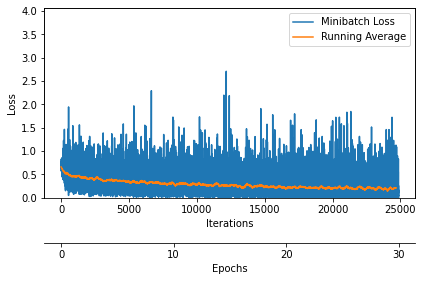

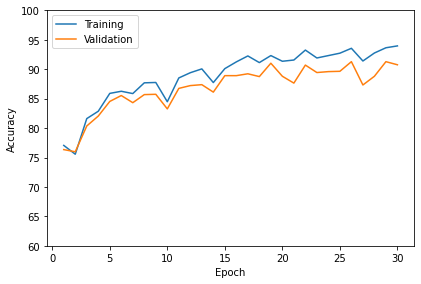

In [35]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [36]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PRML Project/covid 19/weights/m1/vgg16_13_04_only_linear_layers.pth')

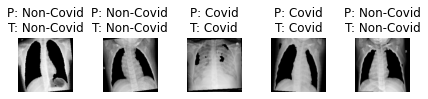

In [38]:
model.cpu()
# unnormalizer = UnNormalize(mean, std)
class_dict = {0: 'Covid',
              1: 'Non-Covid'}
show_examples(model=model, data_loader=test_loader, unnormalizer=None, class_dict=class_dict)

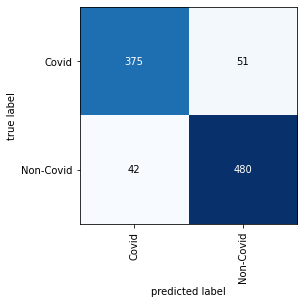

In [39]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

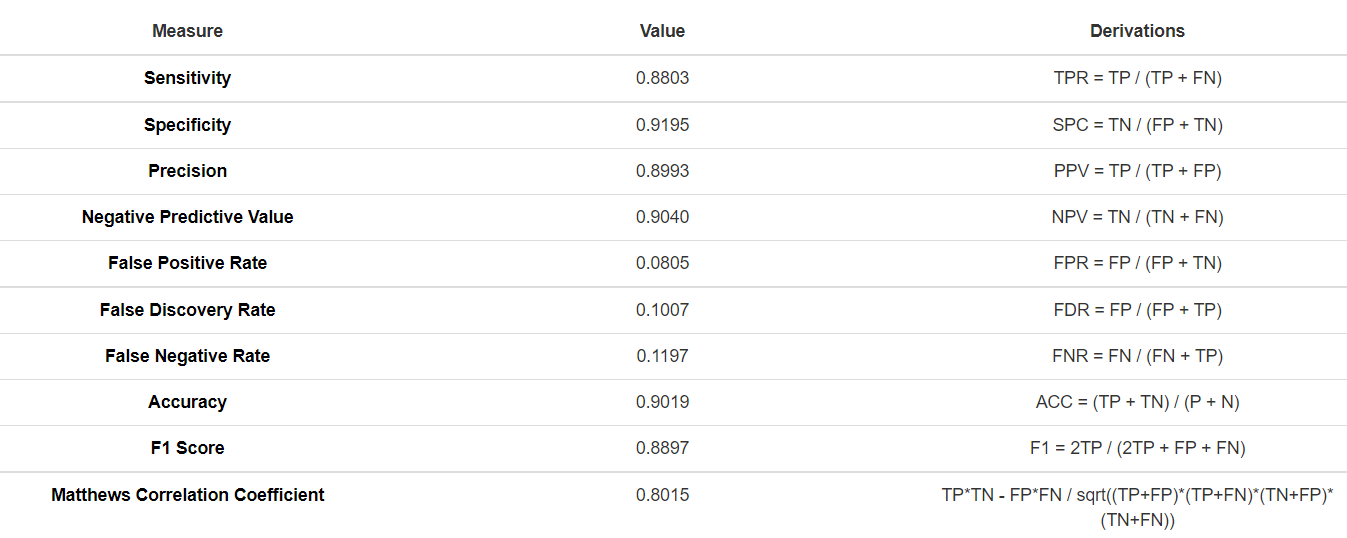